# Read data frame from DB

In [14]:
import psycopg2
import pandas as pd

db_connection = psycopg2.connect(
    host="localhost",
    user="postgres",
    password="password",
    database="postgres"
)

insurance = pd.read_sql("select * from jupyter.insurance;", con=db_connection)
insurance.head()
db_connection.close()

/tmp/ipykernel_49750/869541875.py:11: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



# show Data with seaborn and analyze Data

/home/seyyed/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



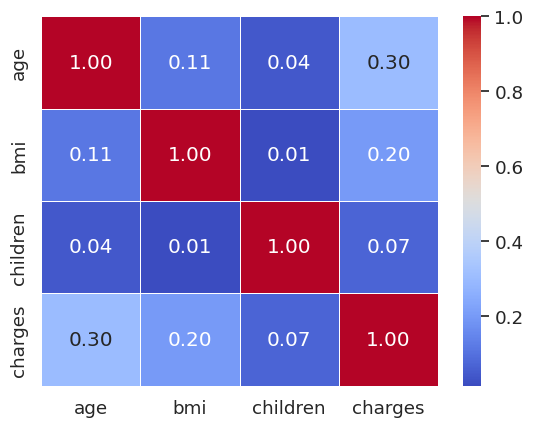

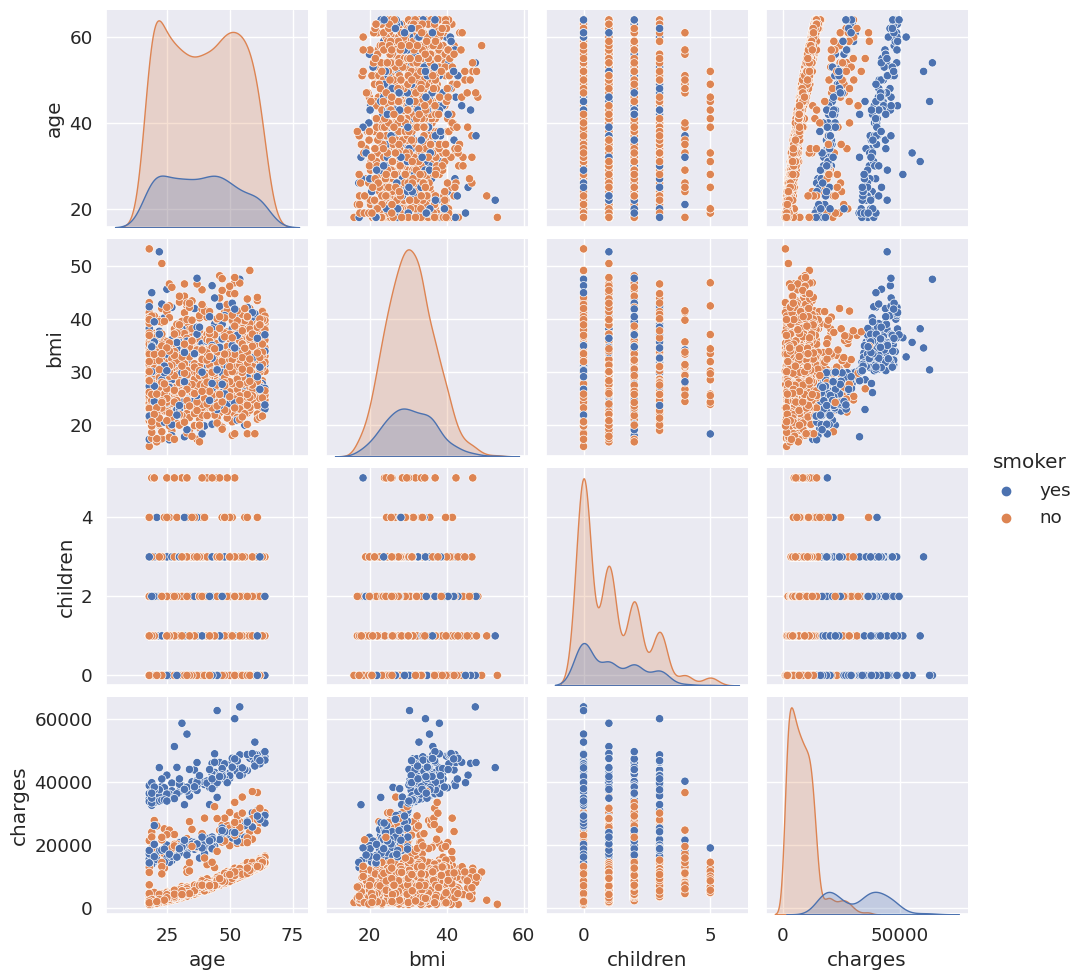

In [15]:
import seaborn as sns
numeric_cols = insurance.select_dtypes(include='number')
corr_matrix = insurance.select_dtypes(include='number').corr()

# Create a heatmap using Seaborn
sns.set(font_scale=1.2)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
# Create pairPlot 
sns.pairplot(data=insurance,hue='smoker')

# Create a sample dataframe with numeric columns
numeric_df = insurance.select_dtypes(include='number')

# Calculate summary statistics of numeric columns
summary = numeric_df.describe().reset_index()

# show correlation heat map with plotly

In [19]:
import dash_table
import numpy as np
from dash import dash, Output, Input
import dash_core_components as dcc
import dash_html_components as html
import plotly.graph_objects as go
import plotly.express as px


# Create a Dash app
app = dash.Dash(__name__)
# create correlation heat map
# Define the callback to switch between tabs and display the corresponding content
@app.callback(
    Output('correlation-heatmap', 'figure'),
    [Input('smoker-dropdown', 'value')]
)
def corr_heat_map(param):
    # Calculate the correlation matrix
    if param is None:
        numeric_df = insurance.select_dtypes(include='number')
    else: numeric_df = insurance[insurance['smoker']==param].select_dtypes(include='number')

    correlation_matrix = numeric_df.corr()
    # Convert correlation matrix to string format
    correlation_text = np.round(correlation_matrix.values, decimals=2).astype(str)
    correlation_text[correlation_text == '1.0'] = '1.00'
    return {
        'data': [
            go.Heatmap(
                x=correlation_matrix.columns,
                y=correlation_matrix.columns,
                z=correlation_matrix.values,
                colorscale='Viridis',
                colorbar=dict(title='Correlation'),
                zmin=-1,  # Set minimum value for color scale
                zmax=1,  # Set maximum value for color scale
            )
        ],
        'layout': go.Layout(
            title='Correlation Heatmap',
            xaxis=dict(title='X'),
            yaxis=dict(title='Y'),
            annotations=[
                go.layout.Annotation(
                    x=x_val,
                    y=y_val,
                    text=str(correlation_text[i, j]),
                    showarrow=False,
                    font=dict(color='black')
                )
                for i, y_val in enumerate(correlation_matrix.columns)
                for j, x_val in enumerate(correlation_matrix.columns)
            ]


        )
    }


correlationHeatMap = dcc.Graph(
    id='correlation-heatmap',
    figure=corr_heat_map(None)
)
options = [{'label': value, 'value': value} for value in insurance.smoker.unique()]
dropDown =  html.Div( children=[html.Div("smoker"),dcc.Dropdown(
        id='smoker-dropdown',
        options=options,
        placeholder='Select a smoker',
        value=None)]
)
#create summary table
summaryTable = dash_table.DataTable(
    data=summary.to_dict('records')
)

heatTab = html.Div([dropDown,correlationHeatMap,dcc.Graph(id='scatter-plot-graph')])

# Define the layout of the application
app.layout = html.Div([
    dcc.Tabs(id='tabs', value='tab-1', children=[
        dcc.Tab(label='Correlation', value='tab-1'),
        dcc.Tab(label='summary statistic', value='tab-2'),
    ]),
    html.Div(id='tab-content')
])




    
# Define the callback to switch between tabs and display the corresponding content
@app.callback(
    Output('tab-content', 'children'),
    [Input('tabs', 'value')]
)
def render_content(tab):
    if tab == 'tab-1':
        return heatTab
    elif tab == 'tab-2':
        return summaryTable
    
@app.callback(
    Output('scatter-plot-graph', 'figure'),
    [Input('correlation-heatmap', 'clickData')]
)
def update_scatter_plot(click_data):
    if click_data is None:
        # Default scatter plot when no cell is clicked
        fig = go.Figure()
    else:
        # Get the clicked cell coordinates
        x = click_data['points'][0]['x']
        y = click_data['points'][0]['y']

        fig = px.scatter(title="scatter plot",data_frame=insurance,x=x,y=y,color="smoker")

    return fig
# Run the app
if __name__ == '__main__':
    app.run_server(port=8085)